## Transfer Learning

In [5]:
from IPython import display
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import copy
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.optim as optim
from torch.utils.data import DataLoader as torch_dataloader
import torchvision
from torchvision import datasets, transforms
import torchvision.models as tv_models
import shutil

## Move data into train, val, test folders

In [10]:
files_moved = 0
if not os.path.exists('data/train/0/Non-Covid (1014).png'):
    for tvt in ['train','val','test']:
        with open(f'S224/{tvt}.csv','r') as f:
            for line in f:
                if line[0] == 'f':
                    continue
                line = line.replace('\n','')
                path,label = line.split(',')
                label = int(float(label))
                os.rename(f'S224/{path}',f"data/{tvt}/{label}/{path.split('/')[-1]}")
                files_moved += 1
print(files_moved)

0


## Build Dataloaders
Reformatted data to work with dataloaders

In [50]:
data_transforms = {
    'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
dataset_train = datasets.ImageFolder('data/train', transform=data_transforms['train'])
dataset_val = datasets.ImageFolder('data/val', transform=data_transforms['val'])
dataset_test = datasets.ImageFolder('data/test', transform=data_transforms['test'])
loader_train = torch_dataloader(dataset_train, batch_size=8, shuffle=True, num_workers=0)
loader_val = torch_dataloader(dataset_val, batch_size=8, shuffle=False, num_workers=0) 
loader_test = torch_dataloader(dataset_test, batch_size=8, shuffle=False, num_workers=0) 

In [29]:
len(dataset_train)

2022

In [30]:
len(loader_train)

253

In [31]:
len(dataset_val)

60

In [32]:
len(loader_val)

8

In [33]:
(x,label)=dataset_train[0]
print(x.shape)
print(label)

torch.Size([3, 224, 224])
0


In [34]:
(x,label)=dataset_train[1000]
print(x.shape)
print(label)

torch.Size([3, 224, 224])
1


Show some images

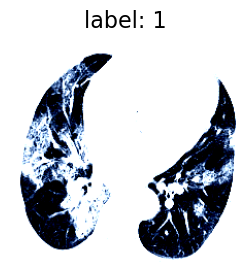

KeyboardInterrupt: 

In [58]:
fig, ax = plt.subplots(figsize=(3, 3))
for n in range(1000, 1010, 1):
    x = dataset_train[n][0].detach().cpu().numpy()
    y = dataset_train[n][1]
    x = x.transpose(1,2,0)
    ax.imshow(x)
    ax.set_title('label: ' + str(y), fontsize=16)
    ax.axis('off')
    display.clear_output(wait=False)
    display.display(fig)
    plt.pause(0.5)  

In [35]:
from torchvision.models import ResNet50_Weights
tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## Define a CNN based on Resnet50

In [36]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()        
        #use resnet50 as the base model
        #self.resnet50 = tv_models.resnet50(pretrained=True) #old Pytorch
        self.resnet50 = tv_models.resnet50(weights=ResNet50_Weights.DEFAULT)
        #modified the last layer for binary classification  
        self.resnet50.fc=torch.nn.Linear(2048, 1) #new layer          
        #freeze all parameters
        for p in self.resnet50.parameters():
            p.requires_grad = False 
        #set the parameters of layer4 to be trainable       
        for p in self.resnet50.layer4.parameters():
            p.requires_grad = True       
        #set the parameters of fc to be trainable       
        for p in self.resnet50.fc.parameters():
            p.requires_grad = True       
        
    def get_trainable_parameters(self):
        pList=list(self.resnet50.layer4.parameters())+list(self.resnet50.fc.parameters())
        #pList=list(self.resnet50.fc.parameters())
        return pList
    
    def forward(self,x):
        z = self.resnet50(x)
        z = z.view(-1)
        return z

In [37]:
def save_checkpoint(filename, model, optimizer, result, epoch):
    torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'result':result},
               filename)
    print('saved:', filename)

## The function to train the model in one epoch

In [38]:
def train(model, device, optimizer, dataloader, epoch):    
    model.train()#set model to training mode
    loss_train=0
    acc_train =0 
    for batch_idx, (X, Y) in enumerate(dataloader):
        #print(X.shape, Y.shape)
        #print(X.dtype, Y.dtype)
        Y = Y.to(X.dtype)
        X, Y = X.to(device), Y.to(device)
        Z = model(X)#forward pass
        loss = nnF.binary_cross_entropy_with_logits(Z, Y)
        optimizer.zero_grad()#clear grad of each parameter
        loss.backward()#backward pass
        optimizer.step()#update parameters
        loss_train+=loss.item()        
        Yp = (Z.data > 0).to(torch.int64)
        Y = Y.to(torch.int64)
        acc_train+= torch.sum(Yp==Y).item()
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{:.0f}%]\tLoss: {:.6f}'.format(
                    epoch, 100. * batch_idx / len(dataloader), loss.item()))
    loss_train/=len(dataloader)
    acc_train/=len(dataloader.dataset) 
    return loss_train, acc_train

## The Function to test the model
It will calculate average accuracy, sensitivity(recall) and precision from the confusion matrix

In [39]:
def test(model, device, dataloader):
    model.eval()#set model to evaluation mode
    loss_test=0
    acc_test =0
    Confusion=np.zeros((2,2))
    with torch.no_grad(): # tell Pytorch not to build graph in the with section
        for batch_idx, (X, Y) in enumerate(dataloader):     
            Y = Y.to(X.dtype)
            X, Y = X.to(device), Y.to(device)
            Z = model(X)#forward pass            
            loss = nnF.binary_cross_entropy_with_logits(Z, Y)
            loss_test+=loss.item()
            Yp = (Z.data > 0).to(torch.int64)
            Y = Y.to(torch.int64)
            acc_test+= torch.sum(Yp==Y).item()
            for i in range(0, 2):
                for j in range(0, 2):
                    Confusion[i,j]+=torch.sum((Y==i)&(Yp==j)).item()
    loss_test/=len(dataloader)        
    acc_test/=len(dataloader.dataset)
    Sens=np.zeros(2)
    Prec=np.zeros(2)   
    for n in range(0, 2):
        TP=Confusion[n,n]
        FN=np.sum(Confusion[n,:])-TP
        FP=np.sum(Confusion[:,n])-TP
        Sens[n]=TP/(TP+FN)
        Prec[n]=TP/(TP+FP)    
    Acc = Confusion.diagonal().sum()/Confusion.sum() # should be the same as acc_test
    return loss_test, acc_test, (Confusion, Acc, Sens, Prec)

## Create a model, and start the training-validation process

In [40]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device', device)
model=Net()
model.to(device)
#optimizer = optim.SGD(model.get_trainable_parameters(), lr=0.0001, momentum=0.99) 
optimizer = optim.Adam(model.get_trainable_parameters(), lr=0.0001) 
#---------------------------------------------------------
(x,label)=dataset_train[0]
x=x.view(1,3,224,224).to(device)
z=model(x)
#
#run this whenever creating a new model
loss_train_list=[]
acc_train_list=[]
loss_val_list=[]
acc_val_list=[]
epoch_save=-1

device cuda:0


In [41]:
z

tensor([0.0098], device='cuda:0', grad_fn=<ViewBackward0>)

In [42]:
y_hat = torch.sigmoid(z)
y_hat

tensor([0.5024], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [43]:
z.shape

torch.Size([1])

In [44]:
def plot_result(loss_train_list, acc_train_list, 
                loss_val_list, acc_val_list):    
    fig, ax = plt.subplots(1, 2, figsize=(12,6))
    ax[0].set_title('loss v.s. epoch',fontsize=16)
    ax[0].plot(loss_train_list, '-b', label='training loss')
    ax[0].plot(loss_val_list, '-g', label='validation loss')
    ax[0].set_xlabel('epoch',fontsize=16)
    #ax[0].set_xticks(np.arange(len(loss_train_list)))
    ax[0].legend(fontsize=16)
    ax[0].grid(True)
    ax[1].set_title('accuracy v.s. epoch',fontsize=16)
    ax[1].plot(acc_train_list, '-b', label='training accuracy')
    ax[1].plot(acc_val_list, '-g', label='validation accuracy')
    ax[1].set_xlabel('epoch',fontsize=16)
    #ax[1].set_xticks(np.arange(len(loss_train_list)))
    ax[1].legend(fontsize=16)
    ax[1].grid(True)
    return fig, ax

In [20]:
#code to update learning rate during training
#lr_new=0.0001
#for g in optimizer.param_groups:
#    g['lr']=lr_new

In [ ]:
# best_acc_val = -99999
for epoch in range(epoch_save+1, epoch_save+30):
    t0=time.time()
    #-------- training --------------------------------
    loss_train, acc_train =train(model, device, optimizer, loader_train, epoch)    
    loss_train_list.append(loss_train)
    acc_train_list.append(acc_train)
    print('epoch', epoch, 'training loss:', loss_train, 'acc:', acc_train)
    #-------- validation --------------------------------
    loss_val, acc_val, other_val = test(model, device, loader_val)
    loss_val_list.append(loss_val)
    acc_val_list.append(acc_val)
    print('epoch', epoch, 'validation loss:', loss_val, 'acc:', acc_val)   
    t1=time.time()
    print("time cost", t1-t0)
    #--------save model-------------------------
    
    result = (loss_train_list, acc_train_list, 
              loss_val_list, acc_val_list, other_val)
    if acc_val > best_acc_val:
        best_acc_val = acc_val
        save_checkpoint('t1_TL_best_1.pt', model, optimizer, result, epoch)
    epoch_save=epoch
    #------- show result ----------------------
    display.clear_output(wait=False)
    plt.close('all')
    fig, ax = plot_result(loss_train_list, acc_train_list, 
                          loss_val_list, acc_val_list)
    display.display(fig)

(<Figure size 1200x600 with 2 Axes>,
 array([<Axes: title={'center': 'loss v.s. epoch'}, xlabel='epoch'>,
        <Axes: title={'center': 'accuracy v.s. epoch'}, xlabel='epoch'>],
       dtype=object))

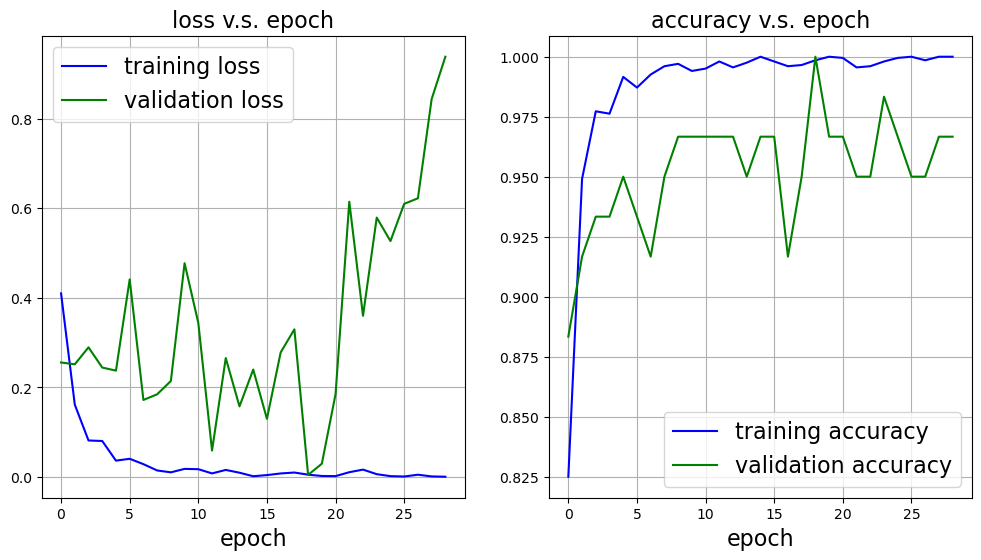

In [46]:
plot_result(loss_train_list, acc_train_list, 
            loss_val_list, acc_val_list)

load the best model

In [47]:
best_id= np.array(acc_val_list).argmax()
best_id

18

In [48]:
epoch_save=best_id
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
checkpoint=torch.load('t1_TL_best_1.pt', map_location=device)
model=Net()
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval() 
#
optimizer = optim.Adam(model.get_trainable_parameters(), lr=0.0001) 
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#
(loss_train_list, acc_train_list, 
 loss_val_list, acc_val_list, other_val) = checkpoint['result']   

In [51]:
loss_test, acc_test, (Confusion, Acc, Sens, Prec) = test(model, device, loader_test)
Confusion_sens=Confusion.copy()
for n in range(0, 2):
    Confusion_sens[n,:]/=np.sum(Confusion[n,:])
Confusion_prec=Confusion.copy()
for n in range(0, 2):
    Confusion_prec[:,n]/=np.sum(Confusion[:,n])
print('TEST SET:\n')
print('Accuracy (average)', acc_test)
print('Accuracy (average)', Acc)
print('Sensitivity', Sens)
print('Precision', Prec)
print('Confusion_sens \n', Confusion_sens)
print('Confusion_prec \n', Confusion_prec)

TEST SET:

Accuracy (average) 0.9775
Accuracy (average) 0.9775
Sensitivity [0.97  0.985]
Precision [0.98477157 0.97044335]
Confusion_sens 
 [[0.97  0.03 ]
 [0.015 0.985]]
Confusion_prec 
 [[0.98477157 0.02955665]
 [0.01522843 0.97044335]]
